In [1]:
import pandas as pd
from utils.plot import plot_categorical_distribution, plot_continuous_distribution
pd.set_option("mode.copy_on_write", True)


In [2]:
%load_ext autoreload
%autoreload 2

# 1. Read datasets
- Read data
- Drop fnlwgt column
- Clean `income` column from test dataset

In [3]:
# Read the data
colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
sensitive_feature = 'sex'
df_train = pd.read_csv('./data/landing/adult.data',
                    sep=', ',
                    header=None,
                    names=colnames,
                    na_values='?',
                    engine='python')

df_train = df_train.drop(columns=['fnlwgt']).dropna() # Drop weighing column

df_test = pd.read_csv('./data/landing/adult.test',
                    sep=', ',
                    header=None,
                    names=colnames,
                    na_values='?',
                    engine='python')
df_test['income'] = df_test['income'].str.replace('.', '', regex=False)

df_test = df_test.drop(columns=['fnlwgt']).dropna() # Drop weighing column

df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Transform
- Get cat and numerical cols
- Define and apply base preprocessing
  - Drop countries different than US
  - Merge 'Married-civ-spouse', 'Married-AF-spouse' and 'Married-spouse-absent' into 'Married'
  - Merge education levels '5th-6th', '1st-4th' and 'Preschool' into 'Below 6th'
  - Merge 'Husband' and 'Wife' into Spouse

In [4]:
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.tolist()

In [5]:
percent_us = len(df_train[df_train['native-country']=='United-States'])/len(df_train)
print('Percentage of samples from the United States: {:.2f}%'.format(percent_us*100))

Percentage of samples from the United States: 91.19%


In [6]:
def arbitrary_preprocessing(df_train, df_test):
    # Drop the columns from the other countries, since US is 91% of the data
    df_train = df_train[df_train['native-country'] == 'United-States'].copy()
    df_test = df_test[df_test['native-country'] == 'United-States'].copy()
    
    # Merge 'Married-civ-spouse', 'Married-AF-spouse' and 'Married-spouse-absent' into 'Married'
    df_train['marital-status'] = df_train['marital-status'].replace(
        ['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent'], 'Married')
    df_test['marital-status'] = df_test['marital-status'].replace(
        ['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent'], 'Married')
    
    # Merge education levels
    df_train['education'] = df_train['education'].replace(
        ['5th-6th', '1st-4th', 'Preschool'], 'Below 6th')
    df_test['education'] = df_test['education'].replace(
        ['5th-6th', '1st-4th', 'Preschool'], 'Below 6th')
    
    # Merge relationship
    df_train['relationship'] = df_train['relationship'].replace(['Husband', 'Wife'], 'Spouse')
    df_test['relationship'] = df_test['relationship'].replace(['Husband', 'Wife'], 'Spouse')
    
    return df_train, df_test

# Apply the function
df_train, df_test = arbitrary_preprocessing(df_train, df_test)

# Profile
- Visualize distributions

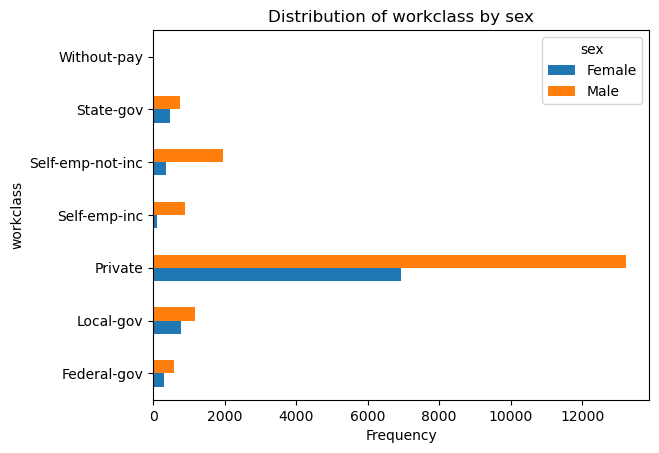

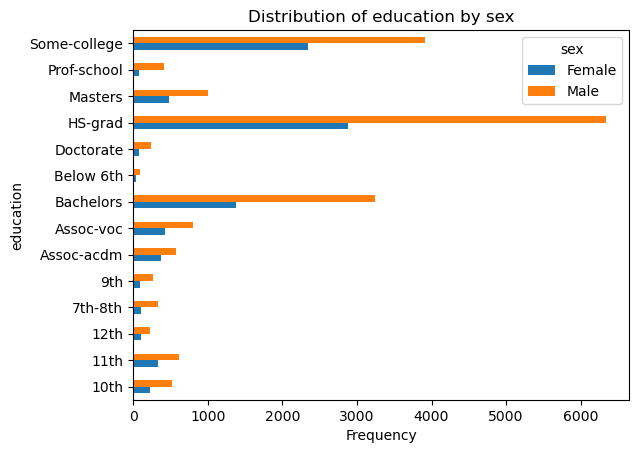

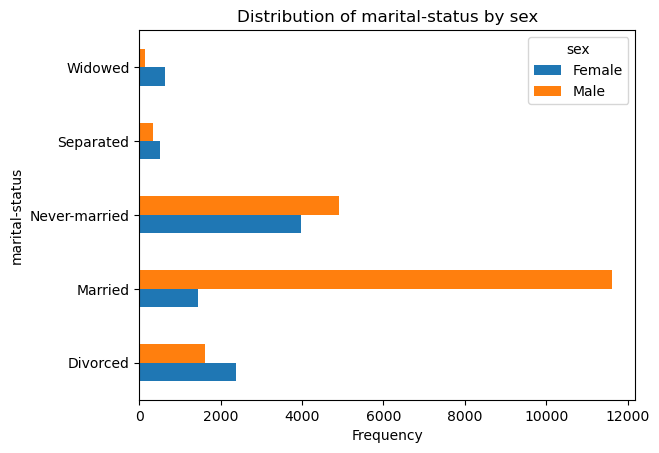

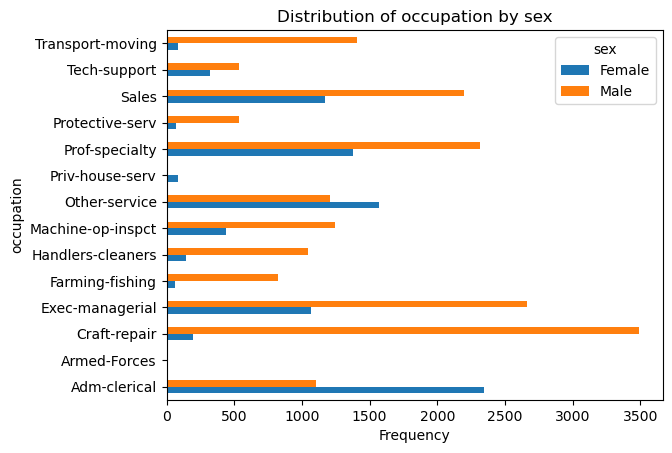

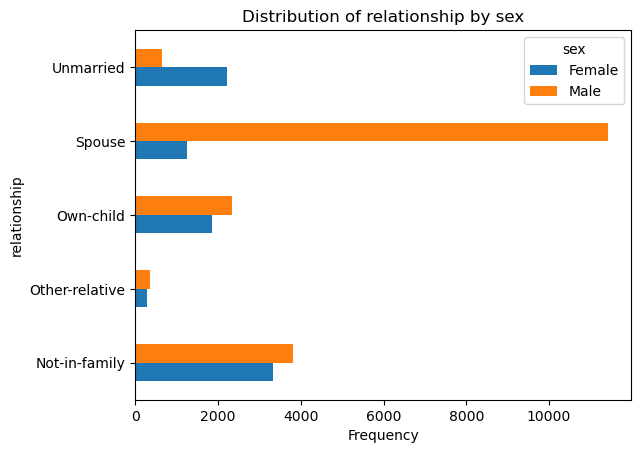

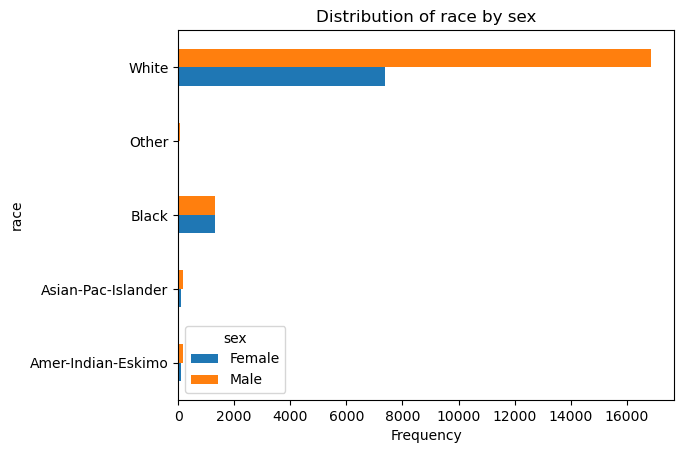

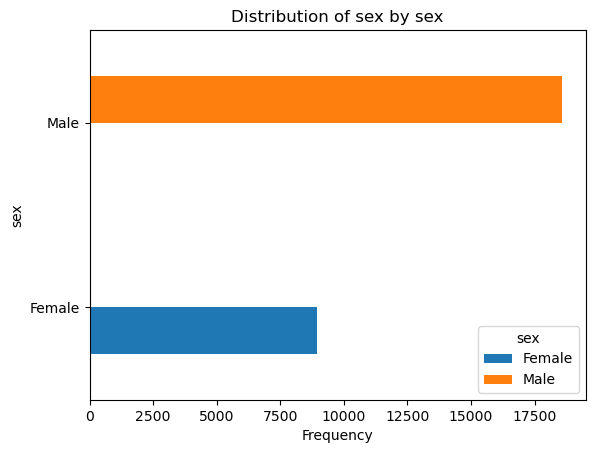

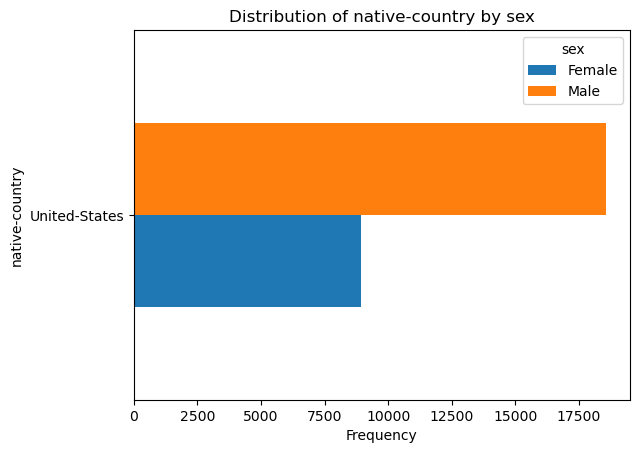

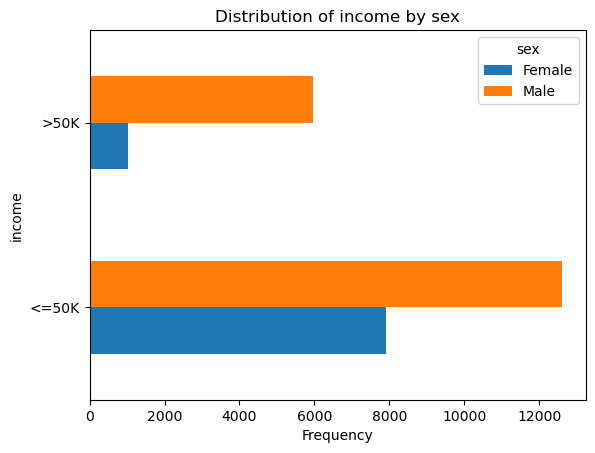

In [7]:
for col in categorical_columns:
    plot_categorical_distribution(df_train, col, sensitive_feature)

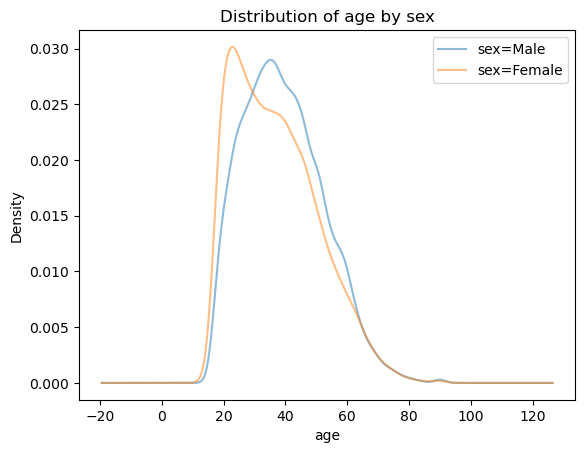

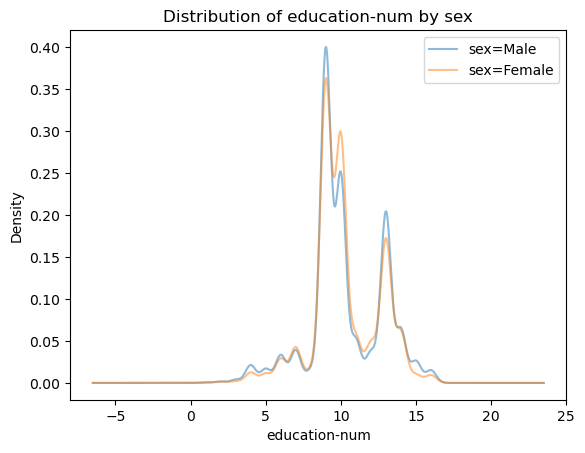

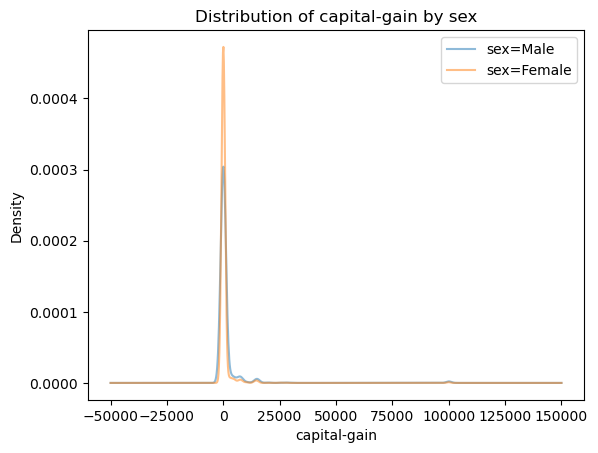

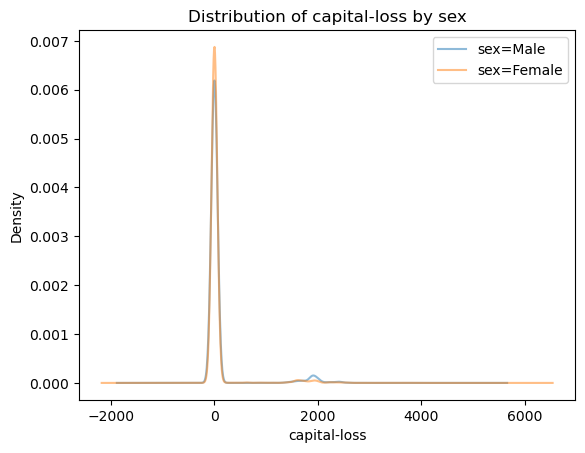

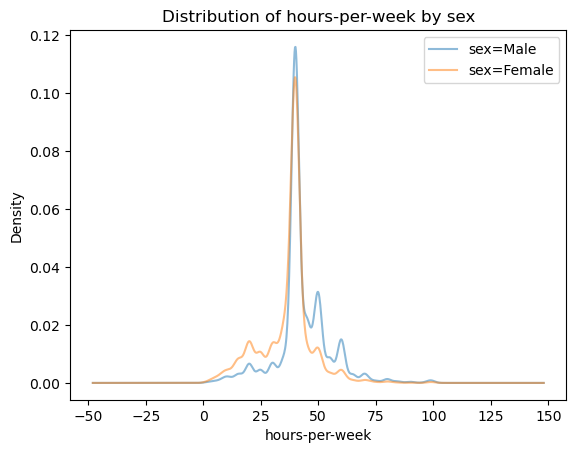

In [8]:
for col in numerical_columns:
    plot_continuous_distribution(df_train, col, sensitive_feature)

In [9]:
df_train.to_csv('./data/transformed/adult_train.csv', index=False)
df_test.to_csv('./data/transformed/adult_test.csv', index=False)


In [105]:
df_cf = df_test.copy()
df_cf['sex'] = df_cf['sex'].replace({'Male': 'Female', 'Female': 'Male'})

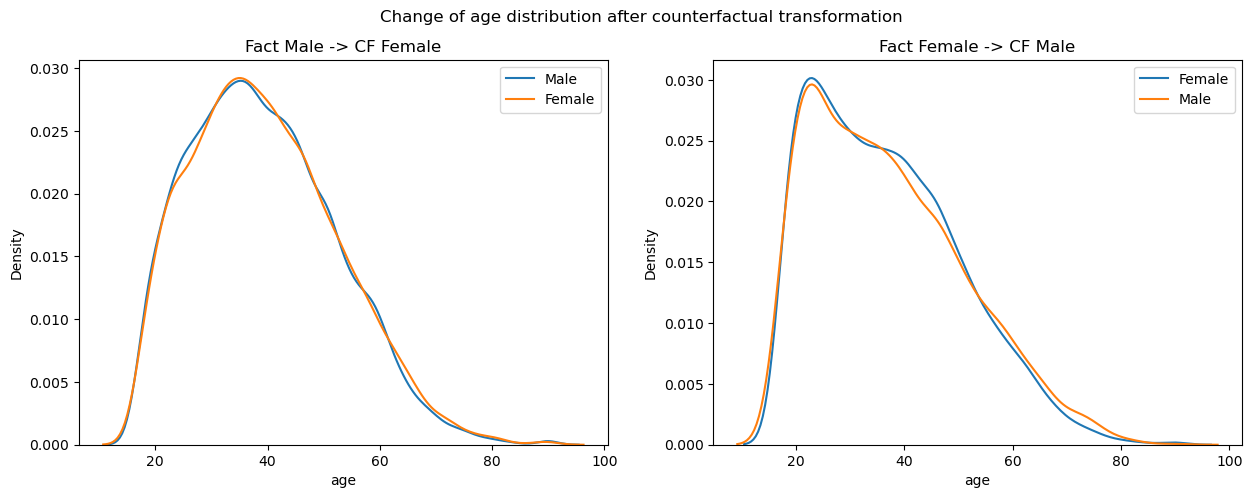

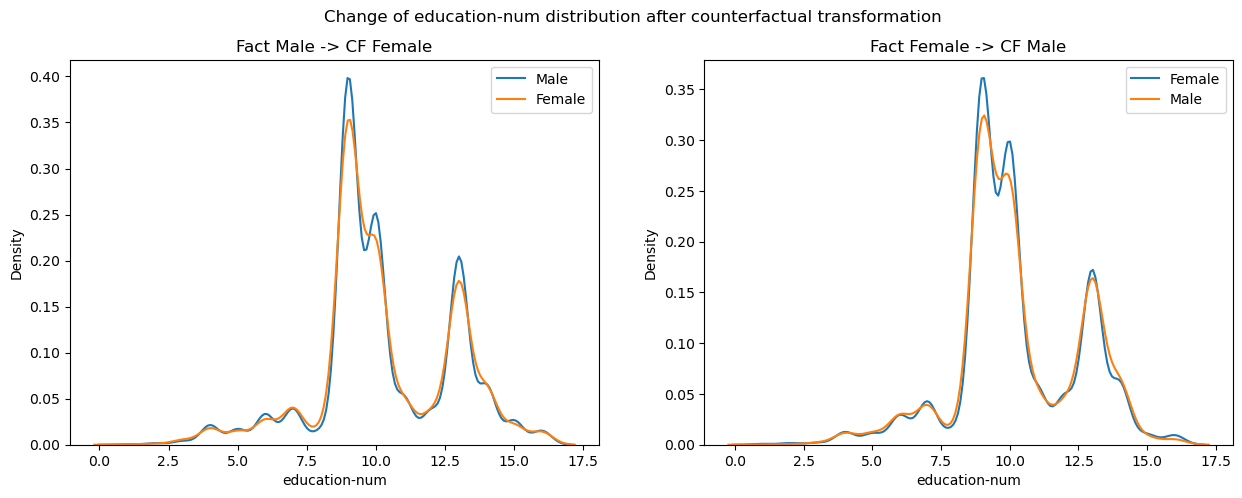

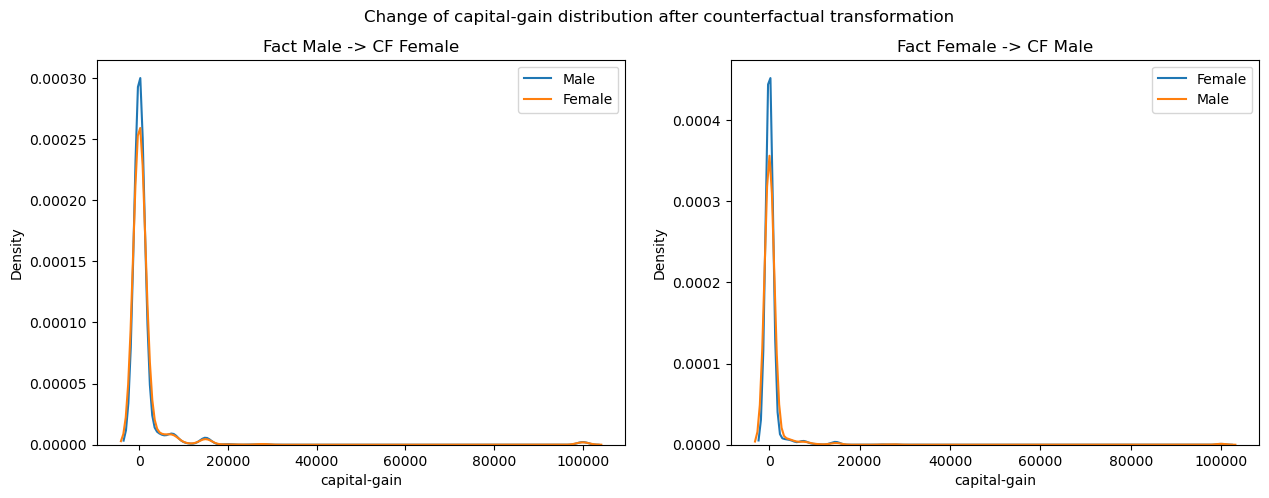

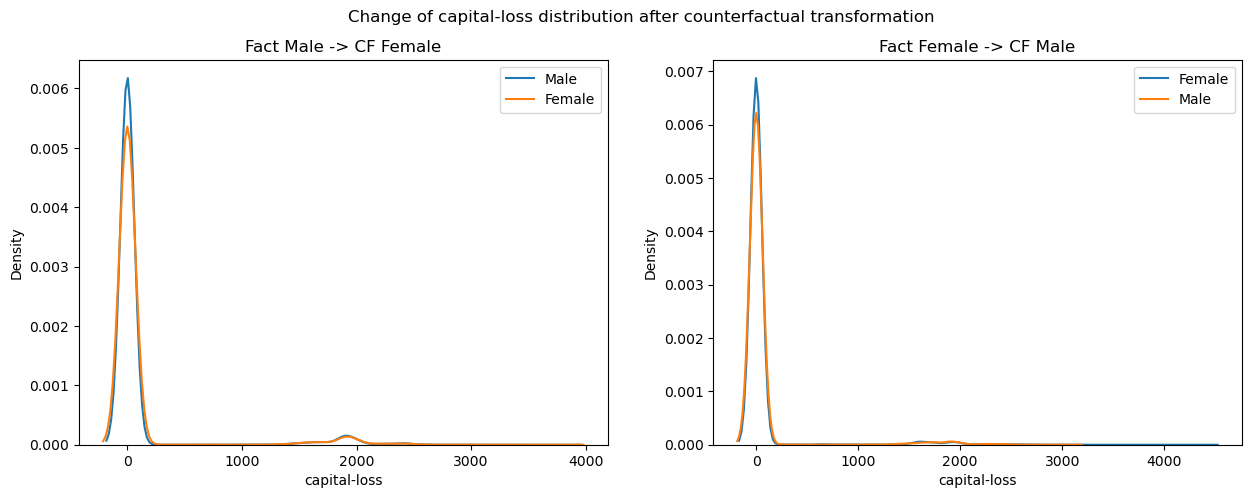

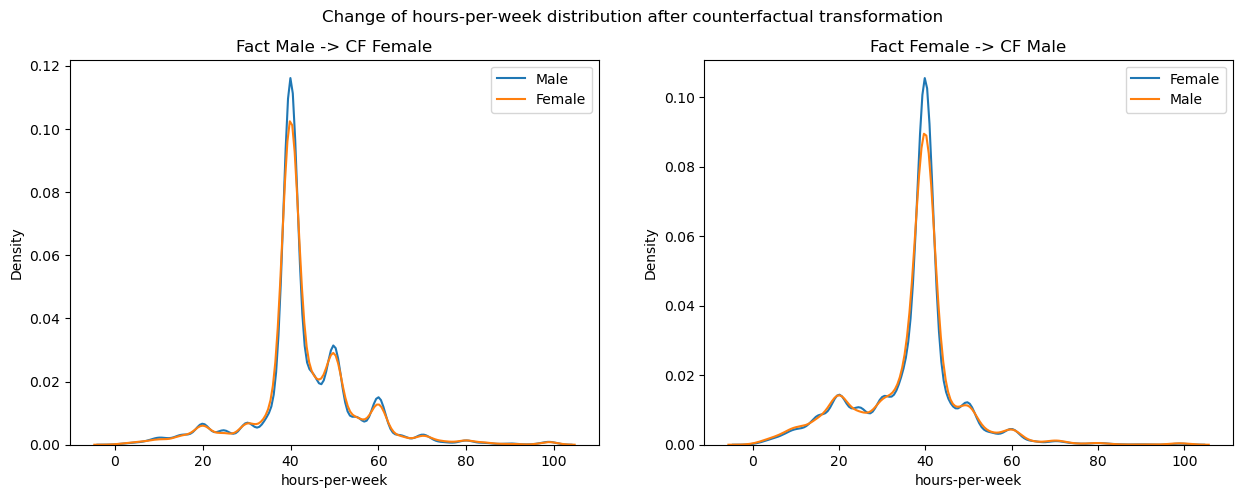

In [139]:
import matplotlib.pylab as plt
import seaborn as sns

def plot_continuous_distribution_comparison(df, df_cf, col, sensitive_feature, subgroups):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    sns.kdeplot(df_train[df_train[sensitive_feature] == subgroups[0]][col], ax=axs[0], label=subgroups[0], legend=True)
    sns.kdeplot(df_cf[df_cf[sensitive_feature] == subgroups[1]][col], ax=axs[0], label=subgroups[1], legend=True)

    sns.kdeplot(df_train[df_train[sensitive_feature] == subgroups[1]][col], ax=axs[1], label=subgroups[1], legend=True)
    sns.kdeplot(df_cf[df_cf[sensitive_feature] == subgroups[0]][col], ax=axs[1], label=subgroups[0], legend=True)

    axs[0].set_title(f'Fact {subgroups[0]} -> CF {subgroups[1]}')
    axs[1].set_title(f'Fact {subgroups[1]} -> CF {subgroups[0]}')

    fig.suptitle(f'Change of {col} distribution after counterfactual transformation')

    axs[0].legend()
    axs[1].legend()
    plt.show()
    
for col in numerical_columns:
    plot_continuous_distribution_comparison(df_test, df_cf, col, sensitive_feature, ['Male', 'Female'])


In [138]:
def filter_df(df, sensitive_feature, subgroup, target_feature, target_value):
    return df[(df[sensitive_feature] == subgroup) & (df[target_feature] == target_value)] 

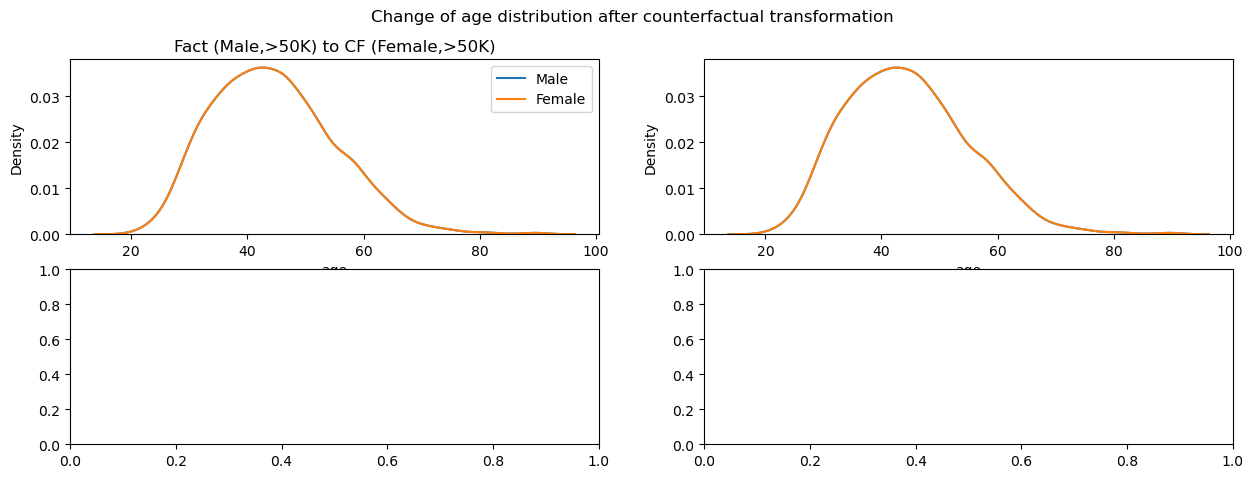

In [ ]:

def plot_continuous_distribution_comparison_per_label(df, df_cf, col, sensitive_feature, subgroups, target_feature, targets):

    fig, axs = plt.subplots(2, 2, figsize=(15, 5))
    sns.kdeplot(filter_df(df, sensitive_feature, subgroups[0], target_feature, targets[0])[col], ax=axs[0][0], label=subgroups[0], legend=True)
    sns.kdeplot(filter_df(df_cf, sensitive_feature, subgroups[1], target_feature, targets[0])[col], ax=axs[0][0], label=subgroups[1], legend=True)

    sns.kdeplot(filter_df(df, sensitive_feature, subgroups[0], target_feature, targets[0])[col], ax=axs[0][1], label=subgroups[0], legend=True)
    sns.kdeplot(filter_df(df_cf, sensitive_feature, subgroups[1], target_feature, targets[0])[col], ax=axs[0][1], label=subgroups[0], legend=True)

    axs[0][0].set_title(f'Fact ({subgroups[0]},{targets[0]}) to CF ({subgroups[1]},{targets[0]})')
    # axs[1].set_title(f'Fact {subgroups[1]} -> CF {subgroups[0]}')

    fig.suptitle(f'Change of {col} distribution after counterfactual transformation')

    axs[0][0].legend()
    # axs[1].legend()
    plt.show()
plot_continuous_distribution_comparison_per_label(df_test, df_cf, 'age', sensitive_feature, ['Male', 'Female'], 'income', ['>50K', '<=50K'])    

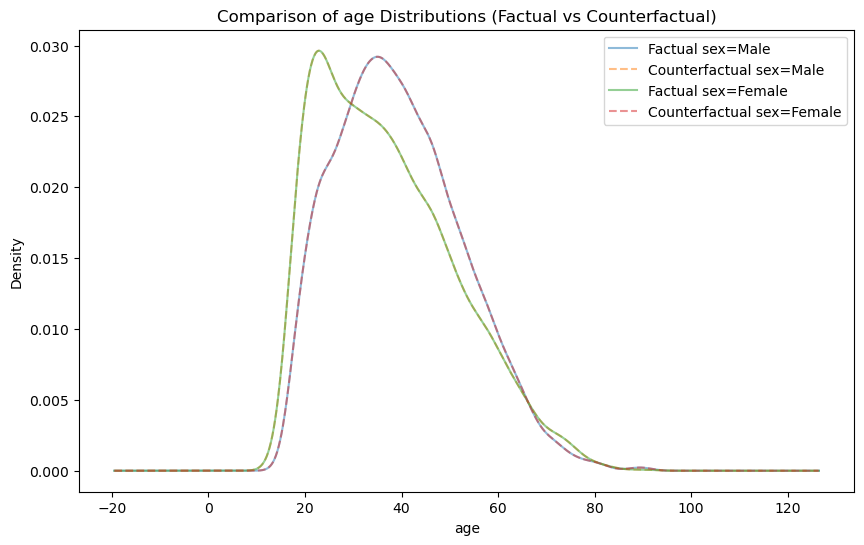

In [81]:
from profile_cfs import plot_distribution_comparison

plot_distribution_comparison(df_test,df_cf, 'age', 'sex')

In [9]:
df_cf.to_csv('./cfs/baseline.csv', index=False)

In [10]:
df.to_csv('./data/adult_train.csv', index=False)